In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load Data
X = np.load("X_features.npy")  # MFCC features
y = np.load("y_labels.npy")  # Labels

In [ ]:
# LDA Functions
def compute_class_means(X, y):
    class_labels = np.unique(y)
    means = {label: np.mean(X[y == label], axis=0) for label in class_labels}
    return means

def compute_within_class_scatter(X, y, means):
    n_features = X.shape[1]
    Sw = np.zeros((n_features, n_features))
    for label, mean in means.items():
        class_scatter = np.dot((X[y == label] - mean).T, (X[y == label] - mean))
        Sw += class_scatter
    return Sw

def compute_between_class_scatter(X, y, means):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    Sb = np.zeros((n_features, n_features))
    for label, mean in means.items():
        n_samples = X[y == label].shape[0]
        mean_diff = (mean - overall_mean).reshape(-1, 1)
        Sb += n_samples * np.dot(mean_diff, mean_diff.T)
    return Sb

def lda(X, y, num_components):
    means = compute_class_means(X, y)
    Sw = compute_within_class_scatter(X, y, means)
    Sb = compute_between_class_scatter(X, y, means)

    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))
    eigvals = eigvals.real  # Keep only real parts
    eigvecs = eigvecs.real  # Keep only real parts

    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]
    return eigvecs[:, :num_components]

def project_data(X, eigenvectors):
    return np.dot(X, eigenvectors)

# Applying LDA
num_classes = len(np.unique(y))
num_components = num_classes - 1
# lda_eigenvectors = lda(X, y, num_components)
# X_lda = project_data(X, lda_eigenvectors)

X_lda = np.load("X_lda.npy") # Loading LDA directly to save processing time.

In [ ]:
# Splitting Data (70-20-10 Train-Test-Val Split)
X_train, X_temp, y_train, y_temp = train_test_split(X_lda, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [ ]:
# Naïve Bayes Classifier
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.class_means = {}
        self.class_variances = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.class_priors[cls] = len(X_cls) / len(y)  # P(y)
            self.class_means[cls] = np.mean(X_cls, axis=0)  # Mean per feature
            self.class_variances[cls] = np.maximum(np.var(X_cls, axis=0), 1e-2)  # Variance per feature

    def gaussian_pdf(self, x, mean, var):
        """Compute Gaussian probability density function."""
        var = np.where(var < 1e-2, 1e-2, var) # Avoid division by zero
        eps = 1e-9
        prob = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((x - mean) ** 2) / (2 * var))
        return np.clip(prob, eps, None)

    def predict(self, X):
        predictions = []
        for x in X:
            class_probs = {}
            for cls in self.classes:
                prior = np.log(self.class_priors[cls])  # Log prior for numerical stability
                likelihoods = np.sum(np.log(self.gaussian_pdf(x, self.class_means[cls], self.class_variances[cls])))
                class_probs[cls] = prior + likelihoods  # Log Posterior = Log Prior + Log Likelihood

            predictions.append(max(class_probs, key=class_probs.get))  # Choose max posterior
        return np.array(predictions)

# Train Naïve Bayes Classifier
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train, y_train)

In [ ]:
# Predict
y_train_pred = nb_classifier.predict(X_train)
y_test_pred = nb_classifier.predict(X_test)
y_val_pred = nb_classifier.predict(X_val)

# Accuracy Calculation
train_accuracy = np.mean(y_train_pred == y_train) * 100
test_accuracy = np.mean(y_test_pred == y_test) * 100
val_accuracy = np.mean(y_val_pred == y_val) * 100

# Print Results
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Train Accuracy: 99.89%
Test Accuracy: 99.80%
Validation Accuracy: 100.00%


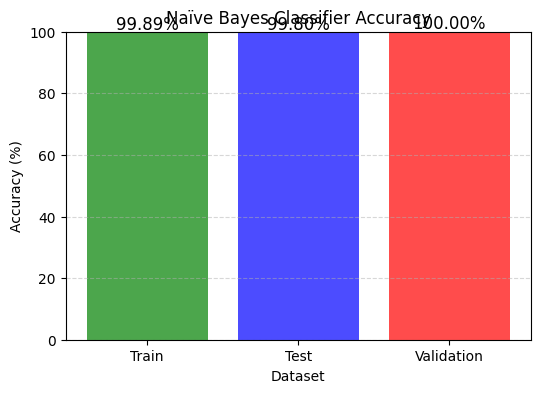

In [ ]:
# Plot Accuracy
plt.figure(figsize=(6, 4))
datasets = ["Train", "Test", "Validation"]
accuracies = [train_accuracy, test_accuracy, val_accuracy]
colors = ["green", "blue", "red"]

plt.bar(datasets, accuracies, color=colors, alpha=0.7)
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.ylabel("Accuracy (%)")
plt.xlabel("Dataset")
plt.title("Naïve Bayes Classifier Accuracy")

# Label bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()